# Inverted Pendulum Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0
    \end{bmatrix}
\end{equation*}
$$

In order to deal with potential angle wrap-around issues (i.e. $2\pi = 0$), we
augment the state as follows and use that instead:

$$
\begin{equation*}
\textbf{x}_{augmented} = \begin{bmatrix}
    \sin\theta & \cos\theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The torque is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.pendulum import InvertedPendulumDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.02
pendulum_length = 1.0
dynamics = InvertedPendulumDynamics(dt, l=pendulum_length)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0]))
Q = np.eye(dynamics.state_size)
Q[0, 1] = Q[1, 0] = pendulum_length
Q[0, 0] = Q[1, 1] = pendulum_length**2
Q[2, 2] = 0.0
Q_terminal = 100 * np.eye(dynamics.state_size)
R = np.array([[0.1]])
cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 300
x0 = dynamics.augment_state(np.array([np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=200, on_iteration=on_iteration)

iteration 0 accepted 1606.00395439 [ 3.03612745  0.63308443]
iteration 1 accepted 1553.46290238 [ 2.74884859  0.51144514]
iteration 2 accepted 1506.92595014 [ 2.58617199  0.79853069]
iteration 3 accepted 1469.79140703 [ 2.27261708  0.48998471]
iteration 4 accepted 1436.36931219 [ 2.19693282  0.45303263]
iteration 5 accepted 1380.56227099 [ 1.95014759  0.25104105]
iteration 6 accepted 1347.02988292 [ 1.76870036  0.11362546]
iteration 7 accepted 1275.5712649 [ 1.46731752  0.06642671]
iteration 8 accepted 1244.3822344 [ 1.28328384  0.02690823]
iteration 9 accepted 1211.49816231 [  1.14305249e+00  -7.26350047e-04]
iteration 10 accepted 1201.52597466 [ 1.04990104 -0.00859394]
iteration 11 accepted 1074.17395252 [ 0.78119359 -0.18371054]
iteration 12 accepted 1049.8600003 [ 0.64122606 -0.26237339]
iteration 13 accepted 1037.23141891 [ 0.52068761 -0.41347838]
iteration 14 accepted 1018.20141402 [ 0.50144941 -0.32171157]
iteration 15 accepted 995.405507241 [ 0.47133001 -0.24623969]
iteration 1

iteration 132 accepted 706.489726739 [ 0.05677429 -0.020389  ]
iteration 133 accepted 706.397073152 [ 0.05657303 -0.02032766]
iteration 134 accepted 706.368864504 [ 0.05564459 -0.02004938]
iteration 135 accepted 706.36253766 [ 0.05527777 -0.01993623]
iteration 136 accepted 706.348669383 [ 0.05491307 -0.01982419]
iteration 137 accepted 706.284116871 [ 0.05472801 -0.01976736]
iteration 138 accepted 706.263006742 [ 0.05387266 -0.01950927]
iteration 139 accepted 706.256959343 [ 0.0535319  -0.01940412]
iteration 140 accepted 706.244313779 [ 0.05319334 -0.01930008]
iteration 141 accepted 706.190957329 [ 0.05302167 -0.01924733]
iteration 142 accepted 706.179743746 [ 0.05222854 -0.0190077 ]
iteration 143 accepted 706.148386527 [ 0.05206679 -0.01895753]
iteration 144 accepted 706.137266864 [ 0.05131635 -0.01872904]
iteration 145 accepted 706.136437423 [ 0.05101301 -0.01863519]
iteration 146 accepted 706.133143407 [ 0.05071202 -0.01854244]
iteration 147 accepted 706.106123269 [ 0.05055956 -0.018

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N) * dt
theta = np.unwrap(xs[:, 0])  # Makes for smoother plots.
theta_dot = xs[:, 1]

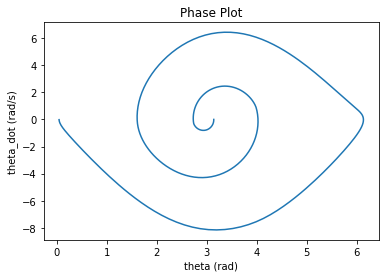

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Phase Plot")

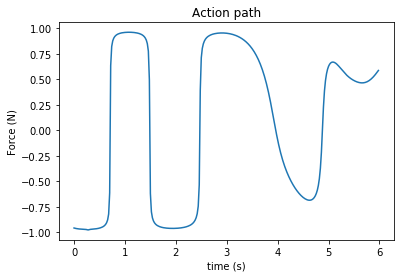

In [13]:
_ = plt.plot(t, us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

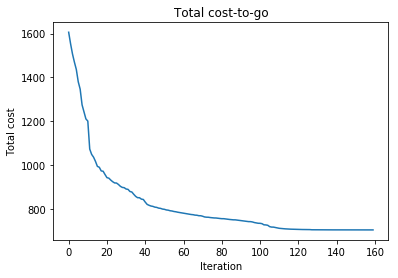

In [14]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")